In [173]:
import pandas as pd
import glob
from obspy.clients.fdsn import Client
import obspy
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
import seisbench.models as sbm

import numpy as np

## The goal of this notebook 

- gather daily detections at all the stations
- find the events that were commonly detected at atleast four stations
- plot waveforms and probability curves of such events

In [135]:
# Compute yesterday’s date in the same format as filenames
yesterday = (datetime.utcnow() - timedelta(days=0)).strftime("%Y-%m-%d")

# Glob files from logs folder using that date
event_files = glob.glob(f"logs/*_{yesterday}_events.csv")


# Load each into a DataFrame
dfs = [pd.read_csv(f) for f in event_files]

# Check how many files loaded
print(f"Loaded {len(dfs)} event files")

Loaded 7 event files


In [136]:
dfs[0]

,station,network,class,auc,mean_prob,max_prob,start_index,end_index,start_time,end_time
0,RCM,UW,eq,2.653574,0.306219,0.535402,17,25,2025-08-06T15:17:49.195401Z,2025-08-06T15:19:09.195401Z
1,RCM,UW,eq,2.726226,0.317760,0.503134,750,758,2025-08-06T17:19:59.195401Z,2025-08-06T17:21:19.195401Z
2,RCM,UW,eq,3.155626,0.367393,0.609299,1014,1022,2025-08-06T18:03:59.195401Z,2025-08-06T18:05:19.195401Z
3,RCM,UW,eq,3.428428,0.354549,0.647598,1048,1057,2025-08-06T18:09:39.195401Z,2025-08-06T18:11:09.195401Z
4,RCM,UW,eq,3.599258,0.421976,0.687755,1279,1287,2025-08-06T18:48:09.195401Z,2025-08-06T18:49:29.195401Z
...,...,...,...,...,...,...,...,...,...,...
200,RCM,UW,su,9.705679,0.318698,0.601592,8253,8283,2025-08-07T14:10:29.195401Z,2025-08-07T14:15:29.195401Z
201,RCM,UW,su,19.845362,0.424606,0.792503,8285,8331,2025-08-07T14:15:49.195401Z,2025-08-07T14:23:29.195401Z
202,RCM,UW,su,10.292741,0.455823,0.791948,8337,8359,2025-08-07T14:24:29.195401Z,2025-08-07T14:28:09.195401Z
203,RCM,UW,su,11.168113,0.405509,0.659032,8366,8393,2025-08-07T14:29:19.195401Z,2025-08-07T14:33:49.195401Z


In [137]:
# Combine all station events into one DataFrame
df_all = pd.concat(dfs, ignore_index=True)

df_all

,station,network,class,auc,mean_prob,max_prob,start_index,end_index,start_time,end_time
0,RCM,UW,eq,2.653574,0.306219,0.535402,17,25,2025-08-06T15:17:49.195401Z,2025-08-06T15:19:09.195401Z
1,RCM,UW,eq,2.726226,0.317760,0.503134,750,758,2025-08-06T17:19:59.195401Z,2025-08-06T17:21:19.195401Z
2,RCM,UW,eq,3.155626,0.367393,0.609299,1014,1022,2025-08-06T18:03:59.195401Z,2025-08-06T18:05:19.195401Z
3,RCM,UW,eq,3.428428,0.354549,0.647598,1048,1057,2025-08-06T18:09:39.195401Z,2025-08-06T18:11:09.195401Z
4,RCM,UW,eq,3.599258,0.421976,0.687755,1279,1287,2025-08-06T18:48:09.195401Z,2025-08-06T18:49:29.195401Z
...,...,...,...,...,...,...,...,...,...,...
1194,MILD,CC,su,8.749862,0.594680,0.932409,8514,8528,2025-08-07T14:53:59.195401Z,2025-08-07T14:56:19.195401Z
1195,MILD,CC,su,6.384266,0.502457,0.818777,8532,8544,2025-08-07T14:56:59.195401Z,2025-08-07T14:58:59.195401Z
1196,MILD,CC,su,9.935370,0.503304,0.825867,8547,8566,2025-08-07T14:59:29.195401Z,2025-08-07T15:02:39.195401Z
1197,MILD,CC,su,7.624577,0.513823,0.887320,8575,8589,2025-08-07T15:04:09.195401Z,2025-08-07T15:06:29.195401Z


In [138]:
# Convert start_time to datetime if it's not already
df_all["start_time"] = pd.to_datetime(df_all["start_time"])

In [139]:
df_all

,station,network,class,auc,mean_prob,max_prob,start_index,end_index,start_time,end_time
0,RCM,UW,eq,2.653574,0.306219,0.535402,17,25,2025-08-06 15:17:49.195401+00:00,2025-08-06T15:19:09.195401Z
1,RCM,UW,eq,2.726226,0.317760,0.503134,750,758,2025-08-06 17:19:59.195401+00:00,2025-08-06T17:21:19.195401Z
2,RCM,UW,eq,3.155626,0.367393,0.609299,1014,1022,2025-08-06 18:03:59.195401+00:00,2025-08-06T18:05:19.195401Z
3,RCM,UW,eq,3.428428,0.354549,0.647598,1048,1057,2025-08-06 18:09:39.195401+00:00,2025-08-06T18:11:09.195401Z
4,RCM,UW,eq,3.599258,0.421976,0.687755,1279,1287,2025-08-06 18:48:09.195401+00:00,2025-08-06T18:49:29.195401Z
...,...,...,...,...,...,...,...,...,...,...
1194,MILD,CC,su,8.749862,0.594680,0.932409,8514,8528,2025-08-07 14:53:59.195401+00:00,2025-08-07T14:56:19.195401Z
1195,MILD,CC,su,6.384266,0.502457,0.818777,8532,8544,2025-08-07 14:56:59.195401+00:00,2025-08-07T14:58:59.195401Z
1196,MILD,CC,su,9.935370,0.503304,0.825867,8547,8566,2025-08-07 14:59:29.195401+00:00,2025-08-07T15:02:39.195401Z
1197,MILD,CC,su,7.624577,0.513823,0.887320,8575,8589,2025-08-07 15:04:09.195401+00:00,2025-08-07T15:06:29.195401Z


In [140]:
# Round to nearest 10s window (you can try 5s or 15s too)
df_all["rounded_start"] = df_all["start_time"].dt.round("10s")

In [141]:
df_all

,station,network,class,auc,mean_prob,max_prob,start_index,end_index,start_time,end_time,rounded_start
0,RCM,UW,eq,2.653574,0.306219,0.535402,17,25,2025-08-06 15:17:49.195401+00:00,2025-08-06T15:19:09.195401Z,2025-08-06 15:17:50+00:00
1,RCM,UW,eq,2.726226,0.317760,0.503134,750,758,2025-08-06 17:19:59.195401+00:00,2025-08-06T17:21:19.195401Z,2025-08-06 17:20:00+00:00
2,RCM,UW,eq,3.155626,0.367393,0.609299,1014,1022,2025-08-06 18:03:59.195401+00:00,2025-08-06T18:05:19.195401Z,2025-08-06 18:04:00+00:00
3,RCM,UW,eq,3.428428,0.354549,0.647598,1048,1057,2025-08-06 18:09:39.195401+00:00,2025-08-06T18:11:09.195401Z,2025-08-06 18:09:40+00:00
4,RCM,UW,eq,3.599258,0.421976,0.687755,1279,1287,2025-08-06 18:48:09.195401+00:00,2025-08-06T18:49:29.195401Z,2025-08-06 18:48:10+00:00
...,...,...,...,...,...,...,...,...,...,...,...
1194,MILD,CC,su,8.749862,0.594680,0.932409,8514,8528,2025-08-07 14:53:59.195401+00:00,2025-08-07T14:56:19.195401Z,2025-08-07 14:54:00+00:00
1195,MILD,CC,su,6.384266,0.502457,0.818777,8532,8544,2025-08-07 14:56:59.195401+00:00,2025-08-07T14:58:59.195401Z,2025-08-07 14:57:00+00:00
1196,MILD,CC,su,9.935370,0.503304,0.825867,8547,8566,2025-08-07 14:59:29.195401+00:00,2025-08-07T15:02:39.195401Z,2025-08-07 14:59:30+00:00
1197,MILD,CC,su,7.624577,0.513823,0.887320,8575,8589,2025-08-07 15:04:09.195401+00:00,2025-08-07T15:06:29.195401Z,2025-08-07 15:04:10+00:00


## Ok so we needed to round off to nearest 10 because of the minor variations in the station detection timing, later all the events that lie within 10s would be merged and counted as one. 

In [142]:
# Group by the rounded start time
grouped = df_all.groupby("rounded_start").agg(
    num_stations=("station", "nunique"),
    stations=("station", lambda x: list(x)),
    most_common_class=("class", lambda x: x.mode()[0] if not x.mode().empty else "unknown"),
    mean_auc=("auc", "mean"),
    mean_max=("max_prob", "mean"),
    mean_prob=("mean_prob", "mean")
).reset_index()

# Show results
print(grouped.head())


              rounded_start  num_stations                       stations  \
0 2025-08-06 15:15:00+00:00             3  [RCM, STAR, STAR, STAR, OBSR]   
1 2025-08-06 15:15:40+00:00             2                   [PANH, MILD]   
2 2025-08-06 15:15:50+00:00             1                          [RER]   
3 2025-08-06 15:16:50+00:00             1                         [STAR]   
4 2025-08-06 15:17:40+00:00             1                          [RCM]   

  most_common_class  mean_auc  mean_max  mean_prob  
0                eq  7.488753  0.778347   0.450346  
1                px  3.854296  0.729158   0.443617  
2                su  3.146884  0.597175   0.366050  
3                su  4.565128  0.831725   0.473200  
4                px  5.185047  0.557468   0.333349  


In [143]:
grouped

,rounded_start,num_stations,stations,most_common_class,mean_auc,mean_max,mean_prob
0,2025-08-06 15:15:00+00:00,3,"[RCM, STAR, STAR, STAR, OBSR]",eq,7.488753,0.778347,0.450346
1,2025-08-06 15:15:40+00:00,2,"[PANH, MILD]",px,3.854296,0.729158,0.443617
2,2025-08-06 15:15:50+00:00,1,[RER],su,3.146884,0.597175,0.366050
3,2025-08-06 15:16:50+00:00,1,[STAR],su,4.565128,0.831725,0.473200
4,2025-08-06 15:17:40+00:00,1,[RCM],px,5.185047,0.557468,0.333349
...,...,...,...,...,...,...,...
1024,2025-08-07 15:06:20+00:00,1,[OBSR],eq,3.496263,0.609882,0.412212
1025,2025-08-07 15:06:30+00:00,1,[RCM],px,4.636081,0.514781,0.281426
1026,2025-08-07 15:06:50+00:00,1,[OBSR],su,9.755366,0.823265,0.470551
1027,2025-08-07 15:07:20+00:00,1,[MILD],su,12.396168,0.922462,0.657938


## Finding events that were commonly detected at four or more stations. 

In [144]:
# Set threshold
N = 4

# Filter the grouped DataFrame
common_events = grouped[grouped["num_stations"] >= N].copy()

# View or save
print(common_events)

                rounded_start  num_stations                       stations  \
365 2025-08-06 21:52:20+00:00             4        [RER, STAR, PANH, MILD]   
651 2025-08-07 04:40:20+00:00             5  [RER, STAR, PANH, PARA, MILD]   
762 2025-08-07 07:14:10+00:00             4       [OBSR, PANH, PARA, MILD]   
927 2025-08-07 12:34:10+00:00             4        [RCM, PANH, PARA, MILD]   

    most_common_class   mean_auc  mean_max  mean_prob  
365                su   5.985605  0.726044   0.447968  
651                eq   4.060372  0.814524   0.435461  
762                su   6.779503  0.843714   0.522712  
927                su  15.290400  0.825750   0.508165  


In [145]:
common_events

,rounded_start,num_stations,stations,most_common_class,mean_auc,mean_max,mean_prob
365,2025-08-06 21:52:20+00:00,4,"[RER, STAR, PANH, MILD]",su,5.985605,0.726044,0.447968
651,2025-08-07 04:40:20+00:00,5,"[RER, STAR, PANH, PARA, MILD]",eq,4.060372,0.814524,0.435461
762,2025-08-07 07:14:10+00:00,4,"[OBSR, PANH, PARA, MILD]",su,6.779503,0.843714,0.522712
927,2025-08-07 12:34:10+00:00,4,"[RCM, PANH, PARA, MILD]",su,15.290400,0.825750,0.508165


## We want to plot these events, their waveforms and probability curves

In [150]:
# Load model
model = sbm.QuakeXNet.from_pretrained("base", version_str = '3')



In [194]:

def plot_event_waveforms(event_row, duration=300, peak_thresh=0.50):
    client      = Client("IRIS")
    event_time  = UTCDateTime(event_row["rounded_start"])
    stations    = event_row["stations"]
    target_cls  = event_row["most_common_class"]

    fig, ax = plt.subplots(figsize=(10, 2 * len(stations)))

    y_offsets = []
    for i, sta in enumerate(stations):
        try:
            st = client.get_waveforms("*", sta, "*", "*HZ",
                                      starttime=event_time,
                                      endtime=event_time + duration)
            st.resample(50)

            # ── inference ───────────────────────────────────────────────
            probs_st = model.annotate(st, stride=500)
            probs_tr = probs_st.select(channel=f"QuakeXNet_{target_cls}")[0]
            t_probs  = probs_tr.times() + 50
            d_probs  = probs_tr.data

            # ── waveform prep ───────────────────────────────────────────
            st.detrend("linear"); st.taper(0.01)
            st.filter("bandpass", freqmin=1, freqmax=20)
            tr       = st[0]
            t_wave   = tr.times("relative")
            y_wave   = tr.data / np.abs(tr.data).max()

            # ── plot ────────────────────────────────────────────────────
            offset = 2 * i
            y_offsets.append(offset)
            ax.plot(t_wave,  y_wave + offset,  lw=0.6, color="black")
            ax.plot(t_probs, d_probs + offset, lw=1.2)

            # annotate peaks above threshold
            peaks = np.where((d_probs[1:-1] > d_probs[:-2]) &
                             (d_probs[1:-1] > d_probs[2:]) &
                             (d_probs[1:-1] >= peak_thresh))[0] + 1
            for p in peaks:
                ax.text(t_probs[p], d_probs[p] + offset + 0.05,
                        f"{d_probs[p]:.2f}", ha="center", va="bottom",
                        fontsize=7, color="darkblue")
        except Exception as e:
            print(f"❌ {sta}: {e}")

    # ── styling ────────────────────────────────────────────────────────
    ax.axvline(0, color="red", ls="--")
    ax.set_xlabel("Time (s)")
    ax.set_title(f"Event @ {event_time.isoformat()} — cls = {target_cls.upper()}")

    # put station names on y-axis at the row centers
    ax.set_yticks(y_offsets)
    ax.set_yticklabels(stations)
    ax.set_ylabel("Station")

    ax.set_xlim(0, duration)
    ax.set_ylim(-1, 2 * len(stations))
    plt.tight_layout()
    plt.show()


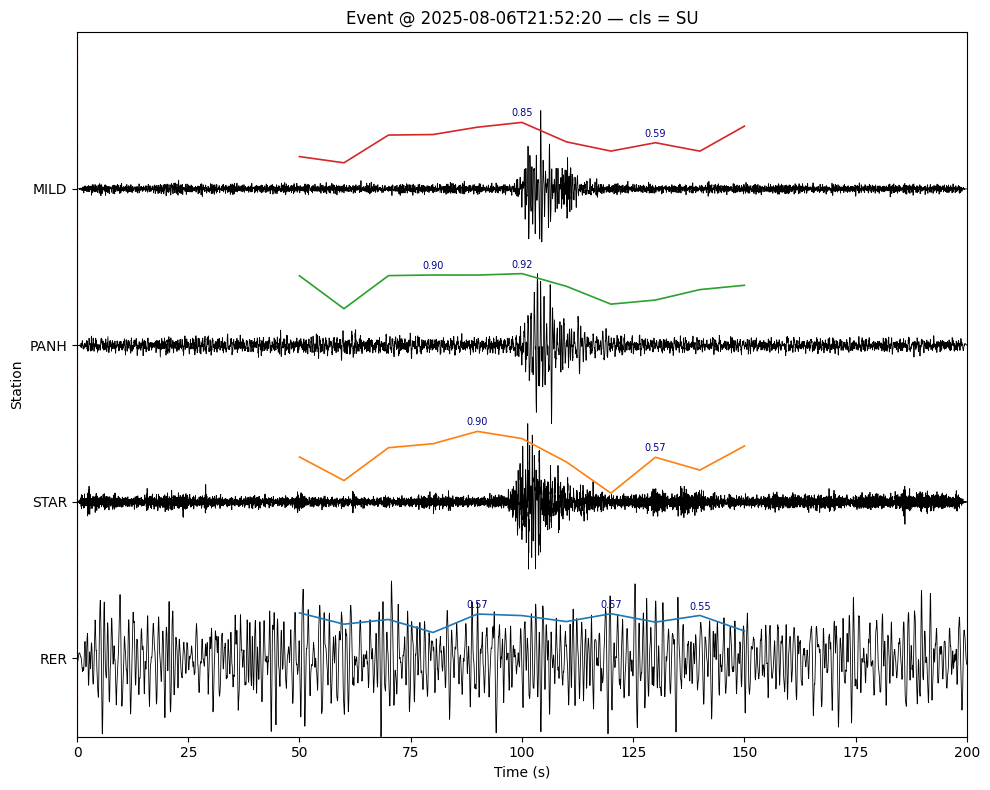

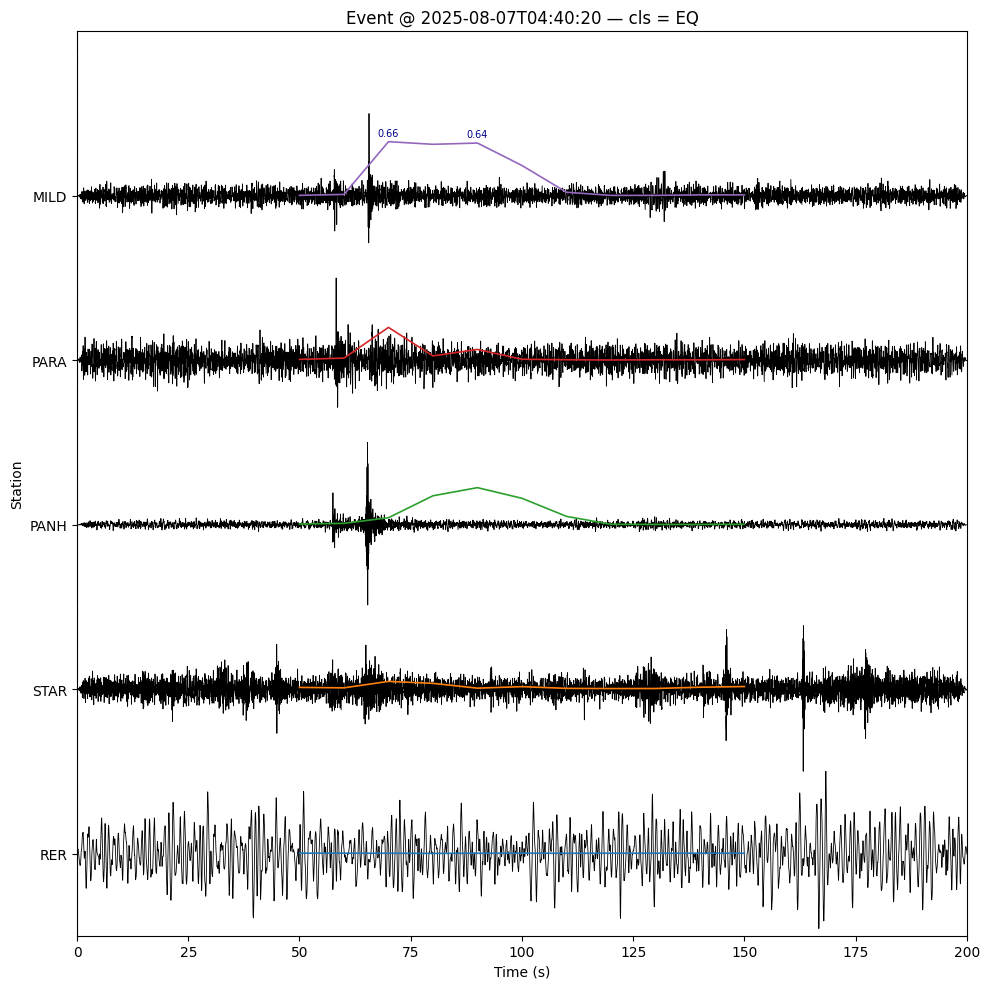

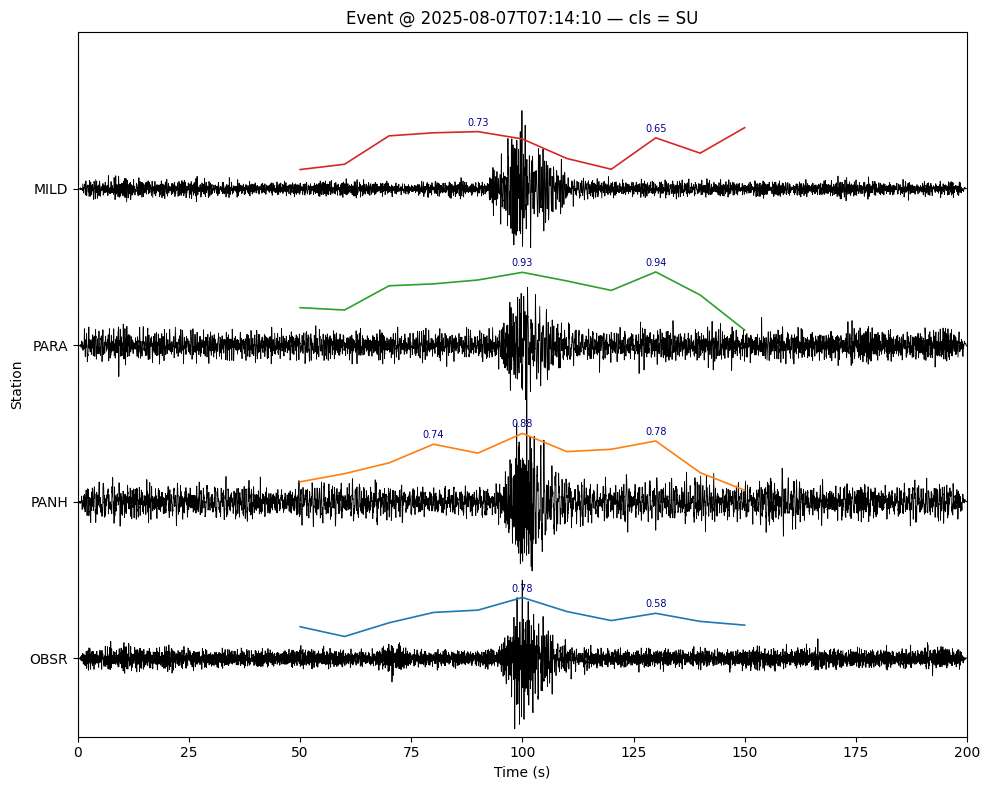

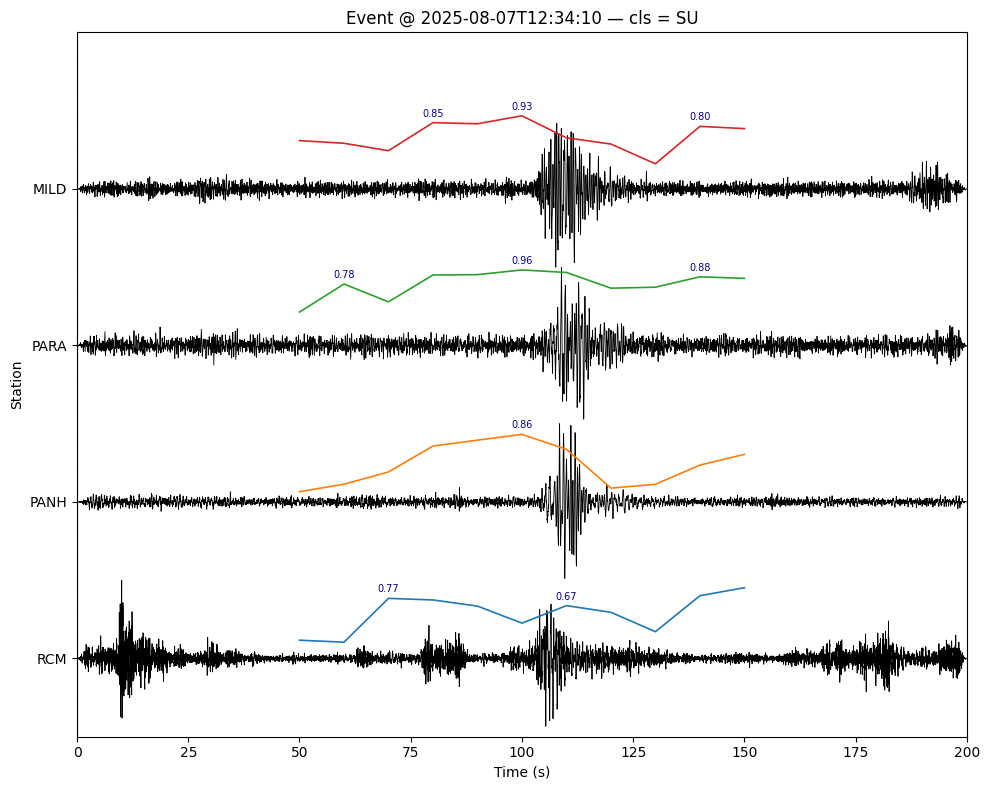

In [195]:
for i in range(len(common_events)):
    plot_event_waveforms(common_events.iloc[i], duration= 200)
